# Assignment 3 - Face Recognition using Eigenfaces

## 1) Preparing the Dataset

First, we need to download the dataset and preprocess the data. To accomplish this, we will load the images into a (N, H, W) NumPy matrix (where N is the number of images, and H, W are the image dimensions). Furthermore, we will also need to center crop the images to remove the background and only keep the face in the images. As an aside, it is also reccomended to make sure the images in our dataset are aligned (e.g., eyes, nose, etc.); the dataset we will be using has already done this for us.

**Bonus:** If you have a few pictures of your friends, you can also supplement the dataset using their photos! Later on we will be building a face recognition system for which you use these photos to test.




### 1.1) First, download the dataset and extract the images

In [1]:
# Download the dataset (subset of CelebA).
!wget -O a3_face_dataset.tar.gz https://www.dropbox.com/s/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz?dl=0

--2019-10-17 00:18:36--  https://www.dropbox.com/s/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz [following]
--2019-10-17 00:18:37--  https://www.dropbox.com/s/raw/4nmsiafyvw0o5fx/a3_face_dataset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdf9dfd18c335f09e2f2d7ae54f.dl.dropboxusercontent.com/cd/0/inline/AqnnTw3Q4qbfxd1Tbx-l6JDducKhtW-sT2sIEyzepUdTQmarHKwXGkK2MkRjXf5ecVXrCHgb87Mbvpp9XwEUqmk3mIMeYoeZ24NHMAzsgSK4_wNmGGzN9dznxnYSpx7WUFg/file# [following]
--2019-10-17 00:18:37--  https://ucdf9dfd18c335f09e2f2d7ae54f.dl.dropboxusercontent.com/cd/0/inline/AqnnTw3Q4qbfxd1Tbx-l6JDducKhtW-sT2sIEyzepUdTQmarHKwXGkK2MkRjXf5ecVXrCHgb87Mb

In [2]:
# Extract the contents of the compressed file.
!tar xzf a3_face_dataset.tar.gz
!ls

a3_face_dataset  a3_face_dataset.tar.gz  sample_data


### 1.2) Preview a few images from the dataset

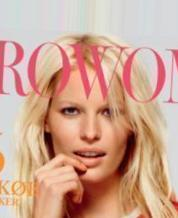

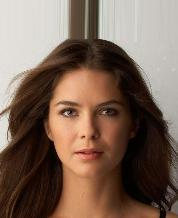

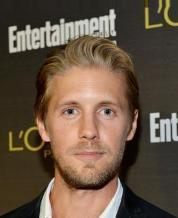

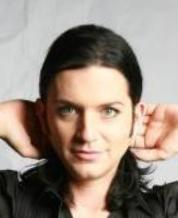

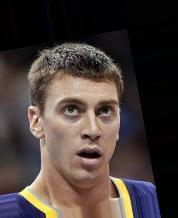

In [3]:
import glob
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Display the first images from the dataset. You can also browse these by
# navigating through the notebooks file system!
sample_images = glob.glob('a3_face_dataset/*.jpg')[:5]
for file_path in sample_images:
  display(Image(file_path))

### 1.3) Load the dataset and convert into a NumPy matrix

In [4]:
import cv2
import numpy as np

# Load images in greyscale.
image_paths = list(glob.glob('a3_face_dataset/*.jpg'))
images = np.stack([cv2.imread(str(x), cv2.IMREAD_GRAYSCALE) 
                   for x in image_paths])
print('Original Image Shape (N, H, W):', images.shape)

Original Image Shape (N, H, W): (500, 218, 178)


###1.4) Center crop the images and visualize the results

Cropped Image Shape (N, H, W): (500, 108, 88)


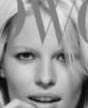

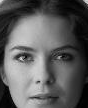

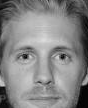

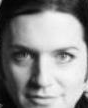

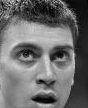

In [5]:
import PIL

# Helper function for cropping the center of the image to remove the background
# and only keep the face.
def center_crop(img):
    h, w = img.shape
    center_y, center_x = h // 2, w // 2
    offset_y, offset_x = center_y // 2, center_x // 2
    return img[center_y - offset_y: center_y + offset_y,
               center_x - offset_x: center_x + offset_x]
  
# Center crop our images.
images = np.stack([center_crop(img) for img in images])
img_height, img_width = images.shape[1:3]
print('Cropped Image Shape (N, H, W):', images.shape)

# Visualize a few results.
for i in range(5):
  display(PIL.Image.fromarray(images[i]))

###1.5) Lastly, flatten each image into a single vector

In [6]:
# Flatten the images into a (N, HxW) sized array, where N is the number of 
# images and H, W are the dimensions of the image.
num_images = len(images)
images = images.reshape(num_images, -1)
print('Matrix Shape (N, H*W):', images.shape)

Matrix Shape (N, H*W): (500, 9504)


## 2) PCA Implementation

For this assignment we will be implementing PCA using only linear algebra libraries. As a guideline, we will loosely follow the interface of the scikit-learn version of PCA. As an added challenge, you are encouraged to implement PCA in a **computationally efficient manner** (i.e., without computing the entirety of the covariance matrix explicitly, as this matrix can be extremely large).

**Please refer to the class notes, and the following resources as a guideline for implementing PCA. Keep in mind that notation may vary between resources; furthermore, make sure that your matrices are arranged in the correct order (e.g., you may need to tranpose your matrix):**
* https://en.wikipedia.org/wiki/Eigenface  
* https://en.wikipedia.org/wiki/Eigenface#Computing_the_eigenvectors  
* http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf  
* http://www.face-rec.org/algorithms/pca/jcn.pdf




In [0]:
import numpy as np
from numpy.linalg import eig

class PCA:
    """
    Custom implementation of PCA with an interface similar to scikit-learn's version of PCA.
    """

    def __init__(self, n_components):
        # TODO: These properties should be populated as appropriate 
        # by the fit method.
        self.n_components_ = n_components
        self.mean_ = None
        self.components_ = None
        self.eigenvalues_ = None

    def fit(self, X):
        # TODO: Complete this method which should compute (and assign) the mean,
        # components, and eigenvalue properties of the PCA object.
        # Remember that we should only retain the n_components with largest 
        # corresponding eigenvalues.
        
        self.mean_ = np.mean(X, axis=0)
        for index in range(len(X)):
          X[index] = np.subtract(X[index], self.mean_)
        
        # Compute the covariance matrix
        cov_mat = np.cov(X)
        # Compute the eigen values and vectors
        eigenvalues, eigenvectors = eig(cov_mat)

        eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

        # Sort the eigen pairs in descending order:
        eig_pairs.sort(reverse=True)
        
        eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
        
        self.eigenvalues_ = eigvalues_sort
        eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]
        
        components = np.array(eigvectors_sort[:self.n_components_]).transpose()
        self.components_ = components
        

    def transform(self, X):
        # TODO: Complete this method. This method takes a matrix of flattened
        # images (N, H*W), subtracts the mean image, and returns the 
        # matrix of images projected onto the principal components.
        for index in range(len(X)):
          X[index] = np.subtract(X[index], self.mean_)
        
        projections = np.dot(X.transpose(), self.components_)
        projections = projections.transpose()
        
        return projections

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

## 3) Computing Eigenfaces

With the implementation of PCA complete, lets try running it on our dataset and visualizing some of the eigenfaces of the training set. To accomplish this, we first run PCA on the training matrix and then we take the eigenvectors and plot them as 2D images.

###3.1) Perform PCA on our image matrix

In [0]:
# Settings
num_components = 50

# PCA
# TODO: Create a PCA object and fit it on the training matrix.

classifier = PCA(num_components)
classifier.fit(images)
projections = classifier.transform(images)

###3.2) Visualize the eigenfaces

Saving mean face...Done.
Saving eigenface 0...Done.
Saving eigenface 1...Done.
Saving eigenface 2...Done.
Saving eigenface 3...Done.
Saving eigenface 4...Done.
Saving eigenface 5...Done.
Saving eigenface 6...Done.
Saving eigenface 7...Done.
Saving eigenface 8...Done.
Saving eigenface 9...Done.
Mean Face


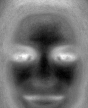

Eigenfaces


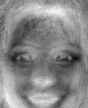

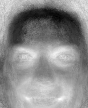

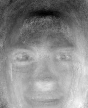

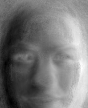

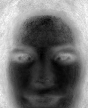

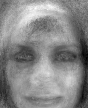

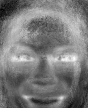

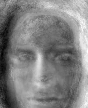

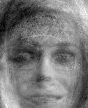

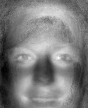

In [11]:
import os
# Output directory.
os.makedirs('./eigenfaces/', exist_ok=True)

# Visualize the mean face.

print('Saving mean face...', end='')
mean_face = classifier.mean_.reshape(img_height, img_width)
norm_img = cv2.normalize(mean_face, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('./eigenfaces/mean_face.png', norm_img)
print('Done.')


# Visualize the eigenfaces.
# TODO: Repeat the procedure performed to visualize the mean face, but
# instead to visualize the first ten eigenfaces. Recall that the components
# computed earlier are flattened and need to be reshaped into the dimensions
# of an image.
for index in range(10):
  print('Saving eigenface {}...'.format(index), end='')
  eigenface = projections[index].reshape(img_height, img_width)
  norm_img = cv2.normalize(eigenface, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  cv2.imwrite('./eigenfaces/eigenface_{}.png'.format(index), norm_img)
  print('Done.')
  

# Display the mean face and eigenfaces. You can also browse these by
# navigating through the notebooks file system!
print('Mean Face')
display(Image('./eigenfaces/mean_face.png'))

print('Eigenfaces')
for img in glob.glob('./eigenfaces/eigenface_*.png'):
  display(Image(img))

###3.3) Variance versus number of components

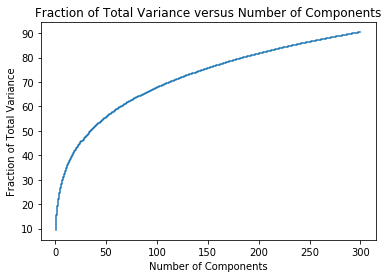

In [12]:
import matplotlib.pyplot as plt

# Compute the cumulative sum of total variance as we increase the number of 
# principal components we use.
n_components_to_plot = 300
total_variance = sum(classifier.eigenvalues_)
var_exp = [(i / total_variance) * 100 for i in
           sorted(classifier.eigenvalues_, reverse=True)[:n_components_to_plot]]
cum_var_exp = np.cumsum(var_exp)

# Generate the plot.
plt.step(range(1, n_components_to_plot + 1), cum_var_exp)
plt.title('Fraction of Total Variance versus Number of Components')
plt.ylabel('Fraction of Total Variance')
plt.xlabel('Number of Components')
plt.show()

## 4) Face Recognition

In this section, we're going to build a simple face recognition system using eigenfaces. To accomplish this, we're going
to take a test image and project it onto our principal components learned from our training set of celebrity faces. Finally, we will compare
the resulting vector to all of the other faces in the training set and find the closest match (i.e., 1-nearest-neighbour classification).

For instance, this training set has photos of Obama -- in theory then, if we were to test another photo of Obama (not in the training set, cropped and aligned), we should find that the closest match in the training set will also be a photo of Obama.

### 4.1) Download the test image

--2019-10-17 00:20:01--  https://www.dropbox.com/s/ffw2621k0gmix1z/006357.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ffw2621k0gmix1z/006357.jpg [following]
--2019-10-17 00:20:01--  https://www.dropbox.com/s/raw/ffw2621k0gmix1z/006357.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucef055ad882d95e4cba6a808057.dl.dropboxusercontent.com/cd/0/inline/Aqla8wUI-GEnWvfApZ5NPB-0SvjELd_0i3c0WLnVrQa1rFo4MCFkZt1h7qO135Nxe8Y1oG8hJ2zBXZl4umkhL5o_YaVwOCrZBmsMqbYLCwJzqXDwFxyuM6fcVwwveN0X_Jc/file# [following]
--2019-10-17 00:20:01--  https://ucef055ad882d95e4cba6a808057.dl.dropboxusercontent.com/cd/0/inline/Aqla8wUI-GEnWvfApZ5NPB-0SvjELd_0i3c0WLnVrQa1rFo4MCFkZt1h7qO135Nxe8Y1oG8hJ2zBXZl4umkhL5o_YaVwOCrZBmsMqbYLCwJzqXDw

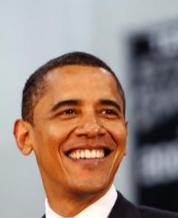

In [13]:
# Download a photo of Obama which isn't in the training set.
!wget -O "006357.jpg" https://www.dropbox.com/s/ffw2621k0gmix1z/006357.jpg?dl=0
display(Image('006357.jpg'))

### 4.2) Find the closest image in the training set to our test image

24
Best match: a3_face_dataset/088848.jpg


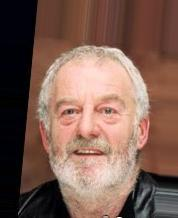

In [15]:
from numpy.linalg import norm
import math

# Load our test image into a NumPy matrix
test_img = center_crop(cv2.imread('006357.jpg', cv2.IMREAD_GRAYSCALE))
test_img = np.expand_dims(test_img.flatten(), axis=0)

# #TODO: Transform our training matrix and test image using our PCA implementation
# from earlier and assign them to the following variables).
transformed_training_matrix = projections

normalised = np.subtract(test_img, classifier.mean_)
transformed_test_img = np.dot(projections, normalised.transpose())

# TODO:
# For our face recognition classifier, we will use a 1-nearest-neighbour
# classifier. Find the image in the training set which is most similar to
# our test image after performing PCA (using Euclidean distance).

ranking = 0

for i in range(len(transformed_training_matrix)):
  dist = norm(transformed_training_matrix[i] - transformed_test_img)
  if i == 0:
    lowest = dist
  if dist < lowest:
    lowest = dist
    ranking = i

# If all goes well, the best match in our training set should be another
# photo of Obama.
print('Best match:', image_paths[ranking])
display(Image(image_paths[ranking]))